# Exercise 04): Monte-Carlo Methods

In this exercise we make use of the racetrack environment (racetrack_environment.py) to test Monte-Carlo methods.

The racetrack environment is based on the OpenAI Gym interface (https://gymnasium.farama.org/) depicted in the picture below.

![](RL_GYM_racetrack.png)

(Source: Wiki, https://www.vecteezy.com/free-vector/car)

The agent can send an action to the system - our racetrack env - using the `env.step(action)` function to drive the car in the environment which is given by the following racetrack: 

![](Racetrack1.png)

Here, the red line represents the start line and the goal is to move the car within the yellow course to the white finish line without hitting the wall. 
If the car hits the wall, it must be returned to the starting line. 
The information we get from the step function of the environment are
- state consisting of the y- and x-postion (`p_y` and `p_x`) and the velocity in x- and y-direction (`v_y` and `v_x`),
- `reward`, which will be -1 per step,
- `terminated`-flag which indicates if the environment is terminated (in our case if the car has reached the finish line),
- `truncated`-flag which is a termination condition outside of the MDP scope, e.g. timelimit, (in our case hitting a wall before the car has reached the finish line),
- info (addioninal information, not used here).

Our possible actions are to accelerate the car into x- and/or y-direction (positiv or negativ) or do nothing.

Accelerate the car will result in chaning the velocity of the car as follows:
![](Beschleunigen.png)

Breaking the car will result in chaning the velocity of the car as follows:
![](break.png)

Our possible action-space is therefore `[-1, 0, 1]` which are availabe as tuple or integer number and encoded as exmplained later on.

Actions (accelerations in given directions) are encoded according from integer (`a`) to tuple (`a_y`, `a_x`) using the follwoing equations:

- `a_y = a//3-1`
- `a_x = a%3-1`

This is shown in the following diagram:

![](Direction_endcoding.png)

Please make yourself more familiar with the used environment (racetrack_environment.py) for more informations.

For the start, please execute the following cells.


In [1]:
import numpy as np
import random
import time
import sys
from racetrack_environment import RaceTrackEnv
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm.notebook import tqdm
plt.style.use('dark_background')

Execute the follwoing cell to built a race track using the `RaceTrackEnv` as a test scenario.  

WWWWWWWWWWWW
WWWWW-oooooW
WWWWW-oooooW
WWWWW-oooooW
WWWWWWWWWooW
WWWWWWWWWooW
WWWWW+oooooW
WWWWW+oooooW
WWWWW+oooooW
WWWWWWWWWWWW


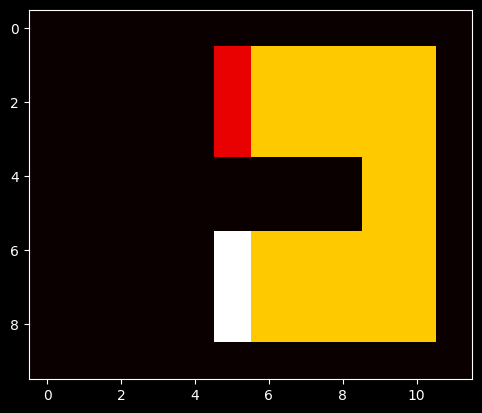

In [2]:
# Build the course
_course_dim = (8, 10)
_inner_wall_dim = (2, 6)

def build_uturn_course(course_dim, inner_wall_dim):
    """
    Build a race track for the u-turn street scenario.
    Start and finish line are placed in the center top and bottom respectively. The course dimension specifications
    do not consider a bounding wall around the track, which is inserted additionally. 

    """
    track = []
    wall_up_bound = course_dim[0]//2 - inner_wall_dim[0] // 2
    wall_bottom_bound = course_dim[0]//2 + inner_wall_dim[0]//2
    street_width = course_dim[1]//2 - inner_wall_dim[1]//2
    # construct course line by line
    for i in range(course_dim[0]):
        if i < wall_up_bound:
            half_street_len = course_dim[1]//2 - 1
            track_row = 'W'*(half_street_len//2+1) + 'W-' + 'o'*(half_street_len-1+half_street_len//2)
        elif  wall_up_bound <= i < wall_bottom_bound:
            track_row = 'W'*street_width + 'W'*inner_wall_dim[1] + 'o'*street_width
        else:
            track_row = 'W'*(half_street_len//2+1) + 'W+' + 'o'*(half_street_len-1+half_street_len//2)
        track.append(track_row)
    # add boundary
    track = ['W'*course_dim[1]] + track + ['W'*course_dim[1]]
    track = ['W'+s+'W' for s in track]
    return track
    
course = build_uturn_course(_course_dim, _inner_wall_dim)
track = RaceTrackEnv(course)
for row in course:
    print(row)
    
pos_map =  track.course  # overlay track course
plt.imshow(pos_map, cmap='hot', interpolation='nearest')
plt.show()

## 1) Monte-Carlo-Based Policy Evaluation

Write a first-visit Monte-Carlo algorithm to evaluate the dummy policy as defined below on the U-turn course. The dummy policy turns the car to the right as soon as it stands in front of a wall. Try to understand how the policy works before you start to code. 

How can we interprete the state values resulting from the evaluation with first-visit Monte-Carlo?

## 1) Solution

Algorithm given below.

The simple and deterministic dummy policy will always guarantee the car to reach the finish line. Thus, the state values can be interpreted as the number of timesteps that is necessary to reach the goal from that specific state (i.e. position and velocity) if we are following the policy.

In [3]:
### Select course and initialize dummy policy

course = build_uturn_course(_course_dim, _inner_wall_dim)
track = RaceTrackEnv(course)
dummy_slow_pi = np.ones([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY]) * 4 

dummy_slow_pi[:track.bounds[0]//2, :, 0 , 0] = 5   # go right
dummy_slow_pi[:track.bounds[0]//2, -2:, 0 , :] = 6 # go bottom left
dummy_slow_pi[-2:, track.bounds[1]//2:, : , 0] = 0 # go top left

pi = dummy_slow_pi

In [4]:
# initialize the value function
values = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY])

# initialize an empty dict to count the number of visits
n_dict = {}

# configuration parameters
gamma = 1 # discount factor
no_episodes = 500 # number of evaluated episodes
no_steps = 2000 # number of allowed timesteps per episode

for e in tqdm(range(no_episodes), position=0, leave=True):
    
    # initialize variables in which collected data will be stored
    states = [] # list of tuples
    rewards = [] # list of floats
    visited_states = set() # set of tuples
    first_visit_list = [] # list of booleans
    
    ### BEGIN SOLUTION
    
    # reset environment and start episode
    p, v = track.reset()
    for k in range(no_steps):
        
        # unpack the statee information
        s_y, s_x = p[0], p[1]
        s_vy, s_vx = v[0], v[1]
        state_tuple = s_y, s_x, s_vy, s_vx
        
        # save the momentary state
        states.append(state_tuple) 
        
        # check momentary state for first visit
        first_visit_list.append(state_tuple not in visited_states)
        visited_states.add(state_tuple)
        
        # choose and perform action
        action = track.action_to_tuple(pi[state_tuple])
        (p, v), reward, terminated, truncated, _ = track.step(action)
        if truncated:
            track.reset()
        
        # save received reward
        rewards.append(reward)
        
        # terminate the environment if the finish line was passed
        if terminated: 
            break 
             
    # learn from the collected data
    g = 0  
    for s, r, first_visit in zip(states[::-1], rewards[::-1], first_visit_list[::-1]): # count backwards
        g = gamma * g + r
        
        if first_visit:
            
            # Count visits to this state in n_list
            n_dict[s] = n_dict.get(s, 0) + 1

            # add new return g to existing value
            values[s] += 1/n_dict[s] * (g-values[s])
            
### END SOLUTION


  0%|          | 0/500 [00:00<?, ?it/s]

To visualize the result of the evaluation, plot the state values as a function of **position only** (so that you get a two dimensional representation of the state value) and in the form of a tabular represenation and a heatmap. In order to omit dependence of the velocity dimensions, use the minimum of the value function with respect to the velocities.

000 000 000 000 000 000 000 000 000 000 000 000
000 000 000 000 000 -17 -16 -15 -14 -13 -12 000
000 000 000 000 000 -16 -15 -14 -13 -12 -11 000
000 000 000 000 000 -15 -14 -13 -12 -11 -10 000
000 000 000 000 000 000 000 000 000 000 -09 000
000 000 000 000 000 000 000 000 000 000 -08 000
000 000 000 000 000 000 000 000 000 000 -07 000
000 000 000 000 000 000 000 000 000 000 -06 000
000 000 000 000 000 000 -01 -02 -03 -04 -05 000
000 000 000 000 000 000 000 000 000 000 000 000


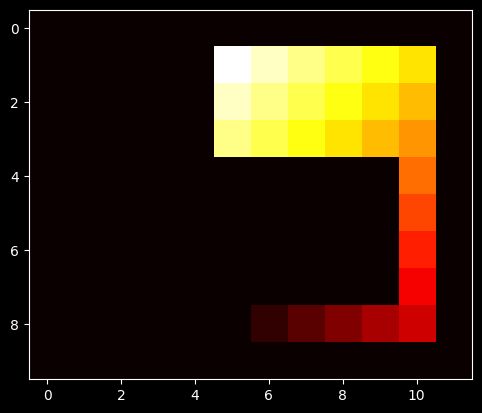

In [5]:
def text_print_pos_map(_pos_map):
    for row in _pos_map:
        print(' '.join(x_size*['{}']).format(*[str(int(r)).zfill(3) for r in row]))
        
def plot_pos_map(_pos_map):
    plt.imshow(_pos_map, cmap='hot', interpolation='nearest')
    plt.show()

# calculate minimum value with respect to velocities
x_size, y_size = len(course[0]), len(course)
pos_map = np.zeros((y_size, x_size))

for s_x in range(x_size):
    for s_y in range(y_size):
        pos_map[s_y, s_x] = np.min(values[s_y, s_x, :, :])
        
text_print_pos_map(pos_map)
plot_pos_map(-pos_map)

## 2) On-Policy $\varepsilon$-Greedy Control

Starting with the previously used turn-right-if-wall dummy policy, write an on-policy Monte-Carlo based first-visit $\varepsilon$-greedy control algorithm to solve the U-turn course. The policy is now stochastic: it does not contain simple action commands for each state, but probabilities for each possible action. Again, please make sure to understand how the stochastic policy works before coding.


Make sure to implement an upper bound for episode length (we suggest a boundary of 200 steps). Why do we need a bound like this? What happens to the state values / state-action values if we increase the bound?

## 2) Solution

Algorithm given below.

As we can see, the dummy policy allows for the initial episode to be solved very fast. After that, the dummy policy is forgotten and it takes some time until the agent is able to solve the problem again. 

The limitation of the episode length forces the agent to learn at least after the allowed number of steps were taken. If one would increase the limit, this would mainly inflate the accumulated return, resulting in larger negative action values for the visited states. As long as we do NOT find the goal, action values will correlate with the time limit. If we find the goal reproducible, the action values will drift towards their true optimal value independently from the time limit.

If we do not implement a time limit and allow the episode to terminate only by reaching the goal, the accumulated negative return will explode (we will get very large numbers). As we try to act greedy (take the highest rated and not the lowest rated action), low action values would suggest that the goal is not to be found on the path taken previously.

In [6]:
# dummy policy
course = build_uturn_course(_course_dim, _inner_wall_dim)
track = RaceTrackEnv(course)

dummy_slow_stoch_pi = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY, 9])

dummy_slow_stoch_pi[  :,   :, :, :, 4] = 1 # set probability of doing nothing to one for every state

# set probability to go right:
dummy_slow_stoch_pi[:track.bounds[0]//2, :, 0 , 0, 5] = 1 
# set probability to do nothing where we want to go right:
dummy_slow_stoch_pi[:track.bounds[0]//2, :, 0 , 0, 4] = 0 

dummy_slow_stoch_pi[:track.bounds[0]//2, -2:, 0 , :, 6] = 1 # probability to go bottom left
dummy_slow_stoch_pi[:track.bounds[0]//2, -2:, 0 , :, 4] = 0 

dummy_slow_stoch_pi[-2:, track.bounds[1]//2:, : , 0, 0] = 1 # probability to go top left
dummy_slow_stoch_pi[-2:, track.bounds[1]//2:, : , 0, 4] = 0 

pi = dummy_slow_stoch_pi                                   

In [7]:
# initialize action_values and counting dict
action_values = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY, 3, 3])
n_dict = {}

# configuration parameters
epsilon = 0.1 # exploration probability
gamma = 1 # discount factor
no_episodes = 5000 # number of evaluated episodes
no_steps = 200 # number of evaluated timesteps per episode
track_maps_l = []  # placeholder for tracks

track = RaceTrackEnv(course)
x_size, y_size = len(course[0]), len(course)

for e in tqdm(range(no_episodes), desc='episode', mininterval=2):
      
    # initialize variables in which collected data will be stored
    action_states = [] # list of tuples
    rewards = [] # list of floats
    visited_action_states = set() # set of tuples
    first_visit_list = [] # list of booleans
    
    pos_map = np.zeros((y_size, x_size)) # initializes a map that can be plotted
    
    ### BEGIN SOLUTION
    
    p, v = track.reset()
    for k in range(no_steps):
        s_y, s_x = p[0], p[1]
        s_vy, s_vx = v[0], v[1]
        
        pos_map[s_y, s_x] += 1  # mark the visited position on the map
        
        # execute action (either by following the policy, or by exploring randomly)
        if epsilon < np.random.rand(1):
            action = np.argmax(pi[s_y, s_x, s_vy, s_vx])
        else:
            action = random.choice(range(9))
        
        # save the action state and check for first visit
        a = track.action_to_tuple(action)
        action_state = track.state_action((p, v), a)
        action_states.append(action_state)
        first_visit_list.append(action_state not in visited_action_states)
        visited_action_states.add(action_state)
        
        # perform action
        (p, v), reward, terminated, truncated, _ = track.step(a)
        if truncated:
            track.reset()
        
        # save received reward
        rewards.append(reward)
        
        # terminate the environment if the finish line was passed
        if terminated:
            break 
    
    # learn from the collected data
    g = 0   
    for r, a_s, first_visit in zip(rewards[::-1], action_states[::-1], first_visit_list[::-1]): # count backwards
        g = gamma * g + r
        
        if first_visit:
            
            # Count visits to this state in n_list
            n_dict[a_s] = n_dict.get(a_s, 0) +  1

            # add new return g to existing value
            action_values[a_s] += 1/n_dict[a_s] * (g - action_values[a_s])
                        
            # calculate the new action probabilities
            u_best = np.argmax(action_values[a_s[:4]])
            pi[a_s[:4]] = epsilon / 9
            pi[a_s[:4]][u_best] = 1 - epsilon + epsilon / 9
    
    
    ### END SOLUTION
    
    # optional value map logging
    track_maps_l.append(track.course + (pos_map > 0).astype(np.float32))



episode:   0%|          | 0/5000 [00:00<?, ?it/s]

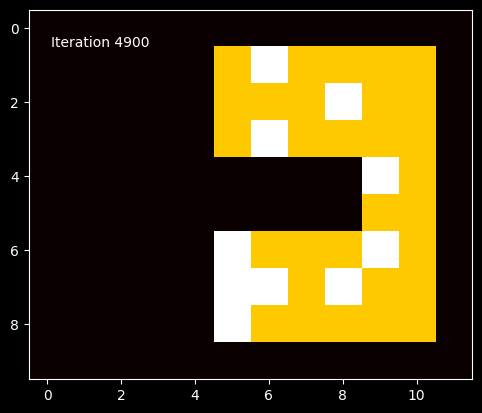

In [8]:
# animate visited tracks    
fig, ax = plt.subplots()
image = plt.imshow(track.course, cmap='hot', interpolation='none')
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def get_render_func(_track_maps_l):
    def animate(it):
        track_map = _track_maps_l[it]
        #image.set_array(track.course)
        image.set_array(track_map)
        time_text.set_text(f"Iteration {it}")
        return image, time_text
    return animate

def init():
    image.set_array(track.course)
    return [image]

ani = animation.FuncAnimation(fig, get_render_func(track_maps_l), frames=range(0, len(track_maps_l), 100), 
                              interval=100, blit=True, init_func=init)
ani.save("solution_2.gif")


![SegmentLocal](solution_2.gif "segment")

Use the code block directly below to test the resulting deterministic greedy policy (several samples are taken in order to show behavior in all different starting positions).

In [9]:
pos_maps_over_eps_l = []
no_episodes = 10
for e in range(no_episodes):
    
    pos_map = np.zeros((y_size, x_size))
    p, v = track.reset()
    for k in range(200):
        s_y, s_x = p[0], p[1]
        s_vy, s_vx = v[0], v[1]
        
        pos_map[s_y, s_x] += 1  # exploration map
        
        action = np.argmax(pi[s_y, s_x, s_vy, s_vx])
        a = track.action_to_tuple(action)
        action_state = track.state_action((p, v), a)

        (p, v), reward, terminated, truncated, _ = track.step(a)

        if truncated:
            track.reset()

        if terminated:
            break 
    pos_map = (pos_map > 0).astype(np.int16)
    pos_map +=  track.course  # overlay track course
    pos_maps_over_eps_l.append(pos_map)

ani = animation.FuncAnimation(fig, get_render_func(pos_maps_over_eps_l),
                              frames=range(0, len(pos_maps_over_eps_l), 1), 
                              interval=500, blit=True, init_func=init)
ani.save("solution_2_2.gif")

![SegmentLocal](solution_2_2.gif "segment")

## 3) Extra Challenge: A More Complex Course

The course given below poses a substantially harder challenge for Monte-Carlo based algorithms. Why? If you want to try solving it yourself, be aware that it may take much longer until a successful policy is found.

WWWWWWWWWWWW
Woooo+W-oooW
Woooo+W-oooW
Woooo+W-oooW
WooWWWWWWooW
WooWWWWWWooW
WooooooooooW
WooooooooooW
WooooooooooW
WWWWWWWWWWWW


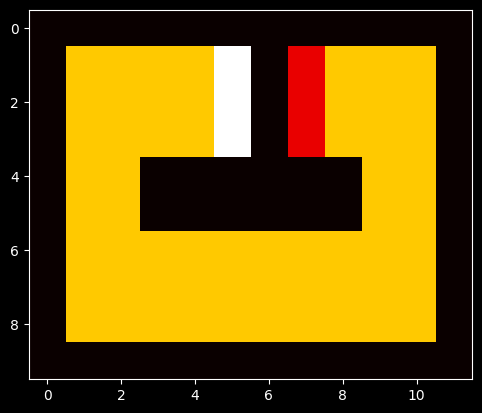

In [10]:
# Build the course
_course_dim = (8, 10)
_inner_wall_dim = (2, 6)

def build_rect_course(course_dim, inner_wall_dim):
    """
    Build a race track given specifications for the outer cyclic street and inner wall dimensions.
    Start and finish line should be placed in the center top. The course dimension specifications
    do not consider a bounding wall around the track, which must be inserted additionally.
    
    Args:
        course_dim: 2-tuple, (y-dim, x-dim): The size of the track without outer walls.
        inner_wall_dim: 2-tuple (y-dim, x-dim): The size of the inner wall
    
    """
    track = []
    wall_up_bound = course_dim[0]//2 - inner_wall_dim[0] // 2
    wall_bottom_bound = course_dim[0]//2 + inner_wall_dim[0]//2
    street_width = course_dim[1]//2 - inner_wall_dim[1]//2
    # construct course line by line
    for i in range(course_dim[0]):
        if i < wall_up_bound:
            half_street_len = course_dim[1]//2 - 1
            track_row = 'o'*half_street_len + '+W-' + 'o'*(half_street_len-1)
        elif  wall_up_bound <= i < wall_bottom_bound:
            track_row = 'o'*street_width + 'W'*inner_wall_dim[1] + 'o'*street_width
        else:
            track_row = 'o'*course_dim[1]
        track.append(track_row)
    # add boundary
    track = ['W'*course_dim[1]] + track + ['W'*course_dim[1]]
    track = ['W'+s+'W' for s in track]
    return track
    
course = build_rect_course(_course_dim, _inner_wall_dim)
track = RaceTrackEnv(course)
for row in course:
    print(row)
    
pos_map =  track.course  # overlay track course
plot_pos_map(pos_map)

## 3) Solution

Taking four turns to reach the goal is way harder than taking just two turns. Additionally, the state space is a lot larger now, which leads to much more exploration being necessary until all the states are properly evaluated. Although the course is more complicated, the problem description ("reach the goal") and the evironment physics (acceleration, momentum and collision) are still the same. Thus, there is no fundamental reason why Monte-Carlo should not be successful here, we just have to be aware that it will take some time.

Fortunately, there are still upcoming lectures where more efficient learning algorithms could be discussed ;)

The following screenshot was taken after trying to solve this problem with the same algorithm as presented in task 2). As can be seen, the agent is actually able to solve the racetrack and reach the finish line. But it took about six hours on a very powerful computer to do so.

![](FullCourse_MonteCarlo_Solved.png)
